In [ ]:
!pip install --quiet git+https://github.com/PatriciaLucas/AutoML.git

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install --quiet langchain
!pip install --quiet langchain_experimental
!pip install --quiet langchain-community
!pip install --quiet langgraph
!pip install --quiet grandalf
!pip install --quiet emd statsmodels pandas numpy

In [ ]:
!pip install --quiet darts

In [ ]:
import os
from getpass import getpass

os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

Digite sua chave da DeepInfra: ··········


**Importando numpy e EMD modules**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emd
import json
import os
from pydantic import BaseModel, Field
from AUTODCETS import datasets
from langchain.chains import LLMChain
from langchain.agents import Tool, ZeroShotAgent, AgentExecutor
from langchain_community.chat_models import ChatDeepInfra
from typing import List, Dict, Any
from langchain.tools import tool, BaseTool
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain.tools.render import render_text_description
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from statsmodels.tsa.stattools import adfuller, kpss
from langchain_core.messages import ToolMessage

In [ ]:
def remover_valores_aleatorios(df, coluna="Close", proporcao=0.1):
    """
    Remove aleatoriamente uma proporção de valores da coluna especificada no DataFrame.
    Plota a série resultante com os valores faltantes visíveis.
    """
    df_modificado = df.copy()

    n = len(df_modificado)
    k = int(n * proporcao)

    # Seleciona posições (inteiros) aleatórias
    posicoes = np.random.choice(n, size=k, replace=False)

    # Apaga os valores com base nas posições
    df_modificado.iloc[posicoes, df.columns.get_loc(coluna)] = np.nan
    pd.DataFrame(df_modificado, columns=[coluna])

    return df_modificado

<Axes: xlabel='Date'>

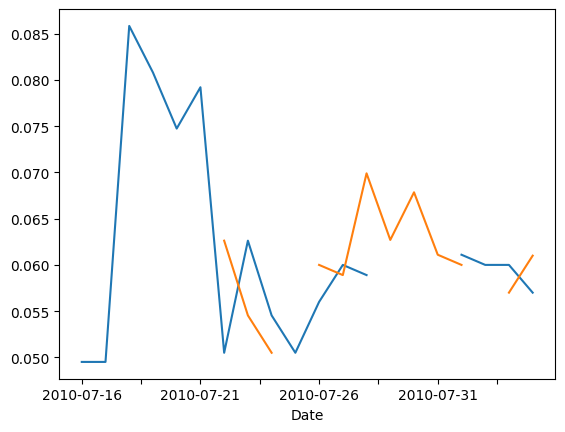

In [ ]:
name = 'ECONOMICS_1'
df = datasets.get_multivariate(name).head(20)
df = remover_valores_aleatorios(df, coluna="Open", proporcao=0.1)
df = remover_valores_aleatorios(df, coluna="Close", proporcao=0.3)
df['Open'].plot()
df['Close'].plot()

In [ ]:
from langchain.tools import tool
from pydantic import BaseModel
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.utils.missing_values import fill_missing_values

class SchemaTools(BaseModel):
    coluna: str


@tool(args_schema=SchemaTools, return_direct=True)
def impute_values_with_linear_method(coluna: str) -> pd.DataFrame:
    """
    Imputa valores ausentes na coluna no DataFrame df utilizando o método de interpolação linear.

    Indicado quando há relação aproximadamente linear entre os pontos adjacentes
    e os valores ausentes estão isolados (sem longas sequências).

    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.

    Retorna df imputado.
    """
    global df

     # Corrige caso o input venha com aspas internas
    coluna = coluna.strip("'").strip('"')

    # 2) Garante índice datetime
    df.index = pd.to_datetime(df.index, errors="raise")

    # 3) Cria TimeSeries preenchendo datas
    series = TimeSeries.from_dataframe(df, fill_missing_dates=True, freq=None)

    # 4) Interpola se necessário
    if df.isna().any().any():
        filler = MissingValuesFiller(fill="auto")
        series_filled = filler.transform(series)
    else:
        series_filled = series

    df = series_filled.to_dataframe()

    return df

@tool(args_schema=SchemaTools, return_direct=True)
def impute_values_with_spline_method(coluna: str) -> pd.DataFrame:
    """
    Imputa valores ausentes na coluna no DataFrame df utilizando interpolação spline (ordem 3).
    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.

    Retorna df imputado.
    """
    global df
    # 1) Garante índice datetime
    df.index = pd.to_datetime(df.index, errors="raise")

    # 2) Cria TimeSeries preenchendo datas
    series = TimeSeries.from_dataframe(df, fill_missing_dates=True, freq=None)

    # 3) Interpola se necessário com spline (ordem 3)
    if df.isna().any().any():
        series_filled = fill_missing_values(
            series,
            fill="auto",
            method="spline",
            order=3,
            limit_direction="both"
        )
    else:
        series_filled = series

    return series_filled.to_dataframe()

@tool(args_schema=SchemaTools, return_direct=True)
def impute_values_with_backfill_method(coluna: str) -> pd.DataFrame:
    """
    Imputa valores ausentes na coluna no DataFrame df utilizando o método de preenchimento para trás (Backward Fill).
    O preenchimento para trás deve ser utilizado quando se assume que o valor ausente pode ser adequadamente representado pela próxima observação disponível.
    É mais indicado quando os dados variam lentamente e não há forte sazonalidade ou padrões complexos que invalidem essa suposição.

    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.

    Retorna df imputado.
    """
    global df
    df = df.fillna(method="bfill")

    return df

@tool(args_schema=SchemaTools, return_direct=True)
def impute_values_with_mean_method(coluna: str) -> pd.DataFrame:
    """
    Imputa valores ausentes na coluna no DataFrame df utilizando a média dos dados.
    A imputação pela média deve ser utilizada em séries temporais aproximadamente estacionárias, onde a média é representativa do comportamento dos dados.
    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.

    Retorna df imputado.
    """
    global df
    df = df.fillna(df.mean())

    return df

@tool(args_schema=SchemaTools, return_direct=True)
def impute_values_with_constant_method(coluna: str) -> pd.DataFrame:
    """
    Imputa valores ausentes na coluna no DataFrame df utilizando um valor constante.
    A imputação por valor constante é adequada quando a ausência de dados possui um significado específico ou quando se deseja padronizar os valores ausentes
    com um número fixo. Pode ser útil para dados categóricos ou quando a ausência de informação é informativa. Pode não ser apropriada para dados numéricos contínuos.
    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.

    Retorna df imputado.
    """
    global df
    df.index = pd.to_datetime(df.index, errors="raise")
    series = TimeSeries.from_dataframe(df, fill_missing_dates=True, freq=None)
    valor_fixo = df[coluna].mean() # Definição do valor fixo a ser imputado. Pensar numa solução em que o agente defini esse valor.

    if df.isna().any().any():
          filler = MissingValuesFiller(fill=valor_fixo)
          series_filled = filler.transform(series)
    else:
        series_filled = series

    impute_results = series_filled.to_dataframe()

    return series_filled.to_dataframe()

@tool(args_schema=SchemaTools, return_direct=True)
def impute_values_with_nearest_method(coluna: str) -> pd.DataFrame:
    """
    Imputa valores ausentes na coluna no DataFrame utilizando o valor mais próximo.
    A imputação pelo valor mais próximo é adequada quando os dados apresentam pouca variação entre pontos adjacentes.
    É especialmente útil em dados categóricos ou ordinais, onde faz sentido substituir o valor ausente pelo vizinho mais próximo observado.
    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.

    Retorna df imputado.
    """
    global df
    df.index = pd.to_datetime(df.index, errors="raise")

    df = df.interpolate(method='nearest', limit_direction='both')

    return df

@tool(args_schema=SchemaTools)
def EMD(coluna: str) -> pd.DataFrame:
    """Decompõe uma série temporal usando o método Empirical Mode Decomposition (EMD).
    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.
    Retorna um dataframe imf com as componentes do EMD.
    """
    global df, imf
    serie = df[coluna].values

    imf = emd.sift.sift(serie)
    imf = pd.DataFrame(imf)

    return imf

@tool(args_schema=SchemaTools)
def testar_estacionariedade(coluna: str) -> str:
    """Determina se uma série temporal é estacionária.
    Argumento: coluna deve conter o nome de uma coluna existente no DataFrame df.
    Retorna uma mensagem indicando se a série é estacionária ou não.
    """
    global df
    serie = df[coluna]

    try:
        # Teste ADF
        adf_resultado = adfuller(serie)
        adf_stat = adf_resultado[0]
        adf_p = adf_resultado[1]
        adf_conclusao = (
            "estacionária" if adf_p < 0.05 else "não estacionária"
        )

        # Teste KPSS
        kpss_resultado = kpss(serie, regression='c', nlags="auto")
        kpss_stat = kpss_resultado[0]
        kpss_p = kpss_resultado[1]
        kpss_conclusao = (
            "não estacionária" if kpss_p < 0.05 else "estacionária"
        )

        if adf_conclusao == "estacionária" and kpss_conclusao == "estacionária":
            return "A série temporal é provavelmente estacionária."
        elif adf_conclusao == "não estacionária" and kpss_conclusao == "não estacionária":
            return "A série temporal é provavelmente não estacionária."
        else:
            return "A série temporal é provavelmente não estacionária."

    except Exception as e:
        return f"Erro ao aplicar os testes: {str(e)}"


import io
import base64
from pydantic import BaseModel
@tool(args_schema=SchemaTools, return_direct=True)
def plot_column_base64(coluna: str) -> str:
    """
    Gera um gráfico de linha da coluna especificada no DataFrame df e retorna a imagem em base64.
    """
    global df
    # Garante que o índice é datetime
    df.index = pd.to_datetime(df.index)

    # Geração do gráfico
    plt.figure(figsize=(10, 5))
    df[coluna].plot(title=f"{coluna}", grid=True)
    plt.xlabel("Data")
    plt.ylabel(coluna)

    # Salvando como imagem em memória
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    plt.close()
    buf.seek(0)

    # Convertendo para base64
    img_base64 = base64.b64encode(buf.read()).decode("utf-8")
    return img_base64

@tool(args_schema=SchemaTools, return_direct=True)
def plot_imf(coluna: str) -> str:
    """
    Gera um gráfico de linha das componentes geradas pela EMD e retorna a imagem em base64.
    """
    global imf
    n_imfs = imf.shape[1]
    fig, axs = plt.subplots(n_imfs, 1, figsize=(12, 2 * n_imfs), sharex=True)

    if n_imfs == 1:
        axs = [axs]  # Garante iterabilidade

    for i, ax in enumerate(axs):
        ax.plot(imf.iloc[:, i], label=f'IMF {i+1}')
        ax.set_ylabel(f'IMF {i+1}')
        ax.legend(loc='upper right')
        ax.grid(True)

    axs[-1].set_xlabel("Índice da série")
    fig.suptitle(f"IMFs da coluna '{coluna}'")
    plt.tight_layout()

    # Salva imagem em buffer e converte para base64
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode("utf-8")
    return img_base64

In [ ]:
# ✅ Etapa 1: Definição das tools

tools = [plot_imf, testar_estacionariedade, EMD, plot_column_base64, impute_values_with_linear_method,
         impute_values_with_nearest_method, impute_values_with_constant_method, impute_values_with_spline_method,
         impute_values_with_mean_method, impute_values_with_backfill_method]

# ✅ Etapa 2: Criação do agente
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

llm = ChatDeepInfra(model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8", temperature=0)
agent = create_pandas_dataframe_agent(
    llm = llm,
    df= pd.DataFrame(df),
    verbose=True,
    allow_dangerous_code=True,
    return_intermediate_steps=True, # Retorna tb os pensamentos e ações do agente
    agent_type="zero-shot-react-description",
    extra_tools = tools,
    max_interations = 10,
    prefix = "Você é um assistente de análise de séries temporais.",   # Comandos ou instruções específicas que definam claramente o papel do agente.
    sufix = """O nome do dataframe é df e ele representa uma série temporal."""    # Instruções específicas que devem vir antes do início da pergunta do usuário.
)


# ✅ Etapa 3: Definir o Estado do Grafo

class State(TypedDict):
    messages: list
    logs: list
    all_tool_outputs: list


graph_builder = StateGraph(State)


# ✅ Etapa 4: Definir os nós

# Função que converte Numpy, Dataframe e Series para dict.
def serialize_output(output):
    if isinstance(output, np.generic):
        return output.item()
    elif isinstance(output, pd.DataFrame):
        return output.reset_index().to_dict(orient="records")
    elif isinstance(output, pd.Series):
        return output.to_dict()
    elif isinstance(output, (list, dict, str, int, float, bool)) or output is None:
        return output
    else:
        return str(output)

def chatbot(state: State): # RECEBE UM STATE COMO PARÂMETRO

    # Salva em agent_output todas as saídas do agente
    agent_output = agent.invoke(state["messages"])
    # print(agent_output)

    # Armazena todos os pensamentos, chamadas das tools e saídas das tools em intermediate_steps
    intermediate_steps = agent_output.get("intermediate_steps", [])

    # Em logs, estou armazenando apenas os pensamentos do agente
    logs = [log.log for log, _ in intermediate_steps]

    # Em tool_outputs, estou armazenando as saídas das tools. A função serialize_output foi necessário para tratar os dados como numpy, dataframes e series.
    tool_outputs = [serialize_output(output) for _, output in intermediate_steps]

    return {"logs": state.get("logs", []) + logs,
            "all_tool_outputs": state.get("all_tool_outputs", []) + tool_outputs
            }

graph_builder.add_node("chatbot", chatbot)              # ADICIONA A ATIVIDADE AO GRAFO

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)  

/usr/local/lib/python3.11/dist-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'max_interations': 10, 'sufix': 'O nome do dataframe é df e ele representa uma série temporal.'} which are no longer supported.
  warnings.warn(


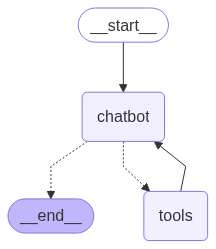

In [ ]:
# ✅ Etapa 5: Criar o grafo

graph_builder.add_edge(START, "chatbot")

# chatbot --> tool
graph_builder.add_conditional_edges("chatbot", tools_condition)

# tool ---> chatbot
graph_builder.add_edge("tools", "chatbot")

checkpointer=MemorySaver()

config = {
    "configurable": {
        "api_key": "rn4xdAxFMIrwoGPUFw7CwmFRDiRKtMQu",  # Your actual key
        "model": llm,  # Your model
        "thread_id": "1"  # Optional conversation tracking
    }
}

graph = graph_builder.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

#Testes com ferramentas de imputação

In [ ]:
# ✅ Etapa 5: Conversar com o agente
estado = graph.invoke({"messages": [HumanMessage(content="O dataframe df possui valores ausentes? Se sim, faça a imputação e retorne o dataframe imputado.")]}, config)



> Entering new AgentExecutor chain...
Thought: Para determinar se o dataframe `df` possui valores ausentes, posso usar a função `isnull().values.any()` no Python. Se houver valores ausentes, vou imputá-los utilizando um método adequado.

Action: python_repl_ast
Action Input: df.isnull().values.any()TrueO dataframe `df` possui valores ausentes. Agora, preciso escolher um método de imputação adequado. Observando os dados, a coluna `Close` parece ter valores ausentes que precisam ser imputados. Vou começar plotando a coluna `Close` para entender melhor o comportamento dos dados.

Action: plot_column_base64
Action Input: CloseiVBORw0KGgoAAAANSUhEUgAAA+gAAAH0CAYAAACuKActAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAboZJREFUeJzt3Xt8zvXj//HnNdvsZEvD5DRskWMqH+Q0EWPDUKjIaR9UQqePU4mKhVQOOYxCilLOh82pWKQPUX2EVDvYwXkOw87bdf3+6Of6Wg45zN7vbY/77dbtxvt6X+/38/Juu97P6/26Xm+LzWazCQAAAAAAGMrB6AAAAAAAAICCDgAAAACAKVDQAQAAAAAwAQo6

In [ ]:
# Todos os pensamentos do agente

estado['logs']

['Thought: Para determinar se o dataframe `df` possui valores ausentes, posso usar a função `isnull().values.any()` no Python. Se houver valores ausentes, vou imputá-los utilizando um método adequado.\n\nAction: python_repl_ast\nAction Input: df.isnull().values.any()',
 'O dataframe `df` possui valores ausentes. Agora, preciso escolher um método de imputação adequado. Observando os dados, a coluna `Close` parece ter valores ausentes que precisam ser imputados. Vou começar plotando a coluna `Close` para entender melhor o comportamento dos dados.\n\nAction: plot_column_base64\nAction Input: Close']

In [ ]:
# Saída da 1ª tool:

estado['all_tool_outputs'][0]

True

In [ ]:
# Saída da 2ª tool:

df_corrigido = pd.DataFrame(estado['all_tool_outputs'][1])
df_corrigido

ValueError: DataFrame constructor not properly called!

#Teste com ferramentas de decomposição

In [ ]:
estado2 = graph.invoke({"messages": [HumanMessage(content="A coluna AVG do dataframe df se beneficiaria da decomposição EMD em tarefas de previsão? Se sim, aplique a decomposição e plote o dataframe resultante da decomposição.")]}, config)

In [ ]:
estado2['logs']

In [ ]:
estado2['all_tool_outputs'][0]

In [ ]:
df_corrigido = pd.DataFrame(estado2['all_tool_outputs'][1])
df_corrigido

In [ ]:
from IPython.display import Image
Image(data=base64.b64decode(estado2['all_tool_outputs'][2]))

#Teste gráfico com retorno e armazenamento em uma variável

In [ ]:
estado3 = graph.invoke({"messages": [HumanMessage(content="Gere um gráfico da coluna Volume do dataframe df e me retorne a imagem.")]}, config)

In [ ]:
from IPython.display import Image
Image(data=base64.b64decode(estado3['all_tool_outputs'][2]))